# Multi-Embedding RAG Comparison
## Testing Multiple Embedding Models with All Retrieval Methods

**Goals:**
1. Compare 2 different embedding models:
   - `sentence-transformers/all-MiniLM-L6-v2` (384 dims, fast)
   - `BAAI/bge-small-en-v1.5` (384 dims, better quality)
2. Test 3 retrieval methods for each:
   - Dense (vector similarity)
   - Sparse (BM25)
   - Hybrid (RRF fusion)
3. Compare performance and quality side-by-side

In [1]:
# Cell 1: Setup and Imports
import os
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root / "src"))

import warnings
warnings.filterwarnings('ignore')

from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# LangChain
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate

# BM25
from rank_bm25 import BM25Okapi

# Utilities
from tqdm.notebook import tqdm
import time
from datetime import datetime

print("✅ All imports successful!")
print(f"Project root: {project_root}")

✅ All imports successful!
Project root: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag


In [2]:
# Cell 2: Configuration with Multiple Embeddings

class Config:
    # Paths
    DATA_DIR = project_root / "data"
    RAW_DIR = DATA_DIR / "raw"
    PROCESSED_DIR = DATA_DIR / "processed"
    VECTOR_STORE_DIR = DATA_DIR / "vector_store"
    
    # Ensure directories exist
    RAW_DIR.mkdir(parents=True, exist_ok=True)
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    VECTOR_STORE_DIR.mkdir(parents=True, exist_ok=True)
    
    # Embedding models to compare
    EMBEDDING_MODELS = {
        'minilm': {
            'name': 'sentence-transformers/all-MiniLM-L6-v2',
            'dims': 384,
            'description': 'Fast, lightweight model'
        },
        'bge_small': {
            'name': 'BAAI/bge-small-en-v1.5',
            'dims': 384,
            'description': 'Better quality, same size'
        }
    }
    
    # LLM configuration
    LLM_MODEL = "llama3.1:8b"
    LLM_TEMPERATURE = 0.1
    
    # Chunking
    CHUNK_SIZE = 512
    CHUNK_OVERLAP = 128
    
    # Retrieval
    TOP_K = 5

config = Config()

print("📊 Embedding Models to Compare:")
for key, model_info in config.EMBEDDING_MODELS.items():
    print(f"  {key}: {model_info['name']}")
    print(f"    - Dims: {model_info['dims']}")
    print(f"    - {model_info['description']}")

📊 Embedding Models to Compare:
  minilm: sentence-transformers/all-MiniLM-L6-v2
    - Dims: 384
    - Fast, lightweight model
  bge_small: BAAI/bge-small-en-v1.5
    - Dims: 384
    - Better quality, same size


In [3]:
# Cell 3: Load and Chunk Documents

def load_and_chunk_pdf(pdf_path: str):
    """Load PDF and create chunks"""
    print(f"📄 Loading PDF: {pdf_path}")
    
    # Load
    loader = PyMuPDFLoader(pdf_path)
    documents = loader.load()
    print(f"   Loaded {len(documents)} pages")
    
    # Chunk
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config.CHUNK_SIZE,
        chunk_overlap=config.CHUNK_OVERLAP,
        separators=["\n\n", "\n", ". ", " ", ""],
    )
    chunks = text_splitter.split_documents(documents)
    
    # Stats
    lengths = [len(chunk.page_content) for chunk in chunks]
    print(f"   Created {len(chunks)} chunks")
    print(f"   Avg length: {np.mean(lengths):.0f} chars")
    print(f"   Range: {np.min(lengths)} - {np.max(lengths)} chars")
    
    return chunks

# Load a sample paper
pdf_path = str(config.RAW_DIR / "bert.pdf")
chunks = load_and_chunk_pdf(pdf_path)

print(f"\n✅ Ready with {len(chunks)} chunks")

📄 Loading PDF: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag/data/raw/bert.pdf
   Loaded 16 pages
   Created 169 chunks
   Avg length: 472 chars
   Range: 138 - 511 chars

✅ Ready with 169 chunks


In [4]:
# Cell 4: Initialize Both Embedding Models

print("🔄 Loading embedding models...\n")

embeddings_dict = {}

for key, model_info in config.EMBEDDING_MODELS.items():
    print(f"Loading {key}: {model_info['name']}")
    
    embeddings = HuggingFaceEmbeddings(
        model_name=model_info['name'],
        model_kwargs={'device': 'cpu'},
        encode_kwargs={'normalize_embeddings': True}
    )
    
    # Test embedding
    test_vec = embeddings.embed_query("test")
    actual_dims = len(test_vec)
    
    embeddings_dict[key] = embeddings
    
    print(f"  ✅ Loaded - Dims: {actual_dims}")
    print()

print(f"✅ All {len(embeddings_dict)} embedding models ready!")

🔄 Loading embedding models...

Loading minilm: sentence-transformers/all-MiniLM-L6-v2


/var/folders/9c/3n849rn554l15tgrg12vm59m0000gn/T/ipykernel_62253/3218800353.py:10: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


  ✅ Loaded - Dims: 384

Loading bge_small: BAAI/bge-small-en-v1.5


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  ✅ Loaded - Dims: 384

✅ All 2 embedding models ready!


In [5]:
# Cell 5: Create Vector Stores for Each Embedding Model

print("🗄️  Creating vector stores...\n")

vectorstores = {}

for key, embeddings in embeddings_dict.items():
    collection_name = f"research_papers_{key}"
    
    print(f"Creating vector store for {key}...")
    print(f"  Collection: {collection_name}")
    print(f"  Chunks: {len(chunks)}")
    
    start_time = time.time()
    
    vectorstore = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        collection_name=collection_name,
        persist_directory=str(config.VECTOR_STORE_DIR)
    )
    
    creation_time = time.time() - start_time
    vectorstores[key] = vectorstore
    
    print(f"  ✅ Created in {creation_time:.2f}s")
    print()

print(f"✅ All {len(vectorstores)} vector stores ready!")

🗄️  Creating vector stores...

Creating vector store for minilm...
  Collection: research_papers_minilm
  Chunks: 169


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


  ✅ Created in 1.56s

Creating vector store for bge_small...
  Collection: research_papers_bge_small
  Chunks: 169
  ✅ Created in 2.60s

✅ All 2 vector stores ready!


In [6]:
# Cell 6: Initialize BM25 (Shared Across Both Embeddings)

class BM25Retriever:
    def __init__(self, chunks):
        """Initialize BM25 with document chunks"""
        self.chunks = chunks
        self.tokenized_docs = [
            doc.page_content.lower().split() 
            for doc in chunks
        ]
        self.bm25 = BM25Okapi(self.tokenized_docs)
    
    def search(self, query: str, k: int = 5):
        """Search using BM25"""
        start_time = time.time()
        tokenized_query = query.lower().split()
        scores = self.bm25.get_scores(tokenized_query)
        top_k_idx = np.argsort(scores)[::-1][:k]
        
        results = []
        for idx in top_k_idx:
            results.append({
                'content': self.chunks[idx].page_content,
                'metadata': self.chunks[idx].metadata,
                'score': float(scores[idx]),
                'index': int(idx)
            })
        
        return results, time.time() - start_time

# Initialize BM25
print("📊 Initializing BM25 retriever...")
bm25_retriever = BM25Retriever(chunks)
print(f"✅ BM25 index created with {len(chunks)} documents")

📊 Initializing BM25 retriever...
✅ BM25 index created with 169 documents


In [7]:
# Cell 7: Retrieval Functions for All Methods

def dense_retrieval(vectorstore, query: str, k: int = 5):
    """Dense retrieval using embeddings"""
    start_time = time.time()
    results = vectorstore.similarity_search_with_score(query, k=k)
    
    formatted_results = []
    for doc, score in results:
        formatted_results.append({
            'content': doc.page_content,
            'metadata': doc.metadata,
            'score': float(score)
        })
    
    return formatted_results, time.time() - start_time

def hybrid_retrieval(
    vectorstore, 
    bm25_retriever, 
    query: str, 
    k: int = 5,
    alpha: float = 0.5
):
    """Hybrid search using RRF"""
    start_time = time.time()
    
    # Get results from both
    dense_results, _ = dense_retrieval(vectorstore, query, k=k*2)
    sparse_results, _ = bm25_retriever.search(query, k=k*2)
    
    # Reciprocal Rank Fusion
    combined_scores = {}
    
    for rank, result in enumerate(dense_results, 1):
        content = result['content']
        combined_scores[content] = alpha / (60 + rank)
    
    for rank, result in enumerate(sparse_results, 1):
        content = result['content']
        if content in combined_scores:
            combined_scores[content] += (1 - alpha) / (60 + rank)
        else:
            combined_scores[content] = (1 - alpha) / (60 + rank)
    
    # Sort and format
    sorted_results = sorted(
        combined_scores.items(), 
        key=lambda x: x[1], 
        reverse=True
    )[:k]
    
    hybrid_results = []
    for content, score in sorted_results:
        orig = next((r for r in dense_results + sparse_results 
                    if r['content'] == content), None)
        hybrid_results.append({
            'content': content,
            'metadata': orig['metadata'] if orig else {},
            'score': score
        })
    
    return hybrid_results, time.time() - start_time

print("✅ Retrieval functions ready!")

✅ Retrieval functions ready!


In [8]:
# Cell 8: Multi-Model Comparison Function

def compare_retrievals(query: str, k: int = 5):
    """
    Compare all retrieval methods across all embedding models
    """
    print("="*80)
    print(f"QUERY: {query}")
    print("="*80)
    
    results = {
        'query': query,
        'timestamp': datetime.now().isoformat(),
        'models': {}
    }
    
    # Test each embedding model
    for model_key in embeddings_dict.keys():
        print(f"\n{'='*80}")
        print(f"MODEL: {model_key.upper()} - {config.EMBEDDING_MODELS[model_key]['name']}")
        print("="*80)
        
        vectorstore = vectorstores[model_key]
        model_results = {}
        
        # Method 1: Dense Retrieval
        print("\n🔍 Method 1: DENSE (Vector Similarity)")
        print("-"*80)
        dense_docs, dense_time = dense_retrieval(vectorstore, query, k=k)
        model_results['dense'] = {
            'results': dense_docs,
            'time': dense_time
        }
        print(f"⏱️  Retrieval time: {dense_time:.4f}s")
        for i, doc in enumerate(dense_docs[:3], 1):
            preview = doc['content'][:120].replace('\n', ' ')
            print(f"{i}. [Score: {doc['score']:.4f}] {preview}...")
        
        # Method 2: Sparse (BM25) - same for all models
        if model_key == list(embeddings_dict.keys())[0]:  # Only show once
            print("\n🔍 Method 2: SPARSE (BM25)")
            print("-"*80)
            sparse_docs, sparse_time = bm25_retriever.search(query, k=k)
            print(f"⏱️  Retrieval time: {sparse_time:.4f}s")
            for i, doc in enumerate(sparse_docs[:3], 1):
                preview = doc['content'][:120].replace('\n', ' ')
                print(f"{i}. [Score: {doc['score']:.4f}] {preview}...")
        
        model_results['sparse'] = {
            'results': sparse_docs if model_key == list(embeddings_dict.keys())[0] else [],
            'time': sparse_time if model_key == list(embeddings_dict.keys())[0] else 0
        }
        
        # Method 3: Hybrid
        print("\n🔍 Method 3: HYBRID (RRF: Dense + BM25)")
        print("-"*80)
        hybrid_docs, hybrid_time = hybrid_retrieval(
            vectorstore, bm25_retriever, query, k=k, alpha=0.5
        )
        model_results['hybrid'] = {
            'results': hybrid_docs,
            'time': hybrid_time
        }
        print(f"⏱️  Retrieval time: {hybrid_time:.4f}s")
        for i, doc in enumerate(hybrid_docs[:3], 1):
            preview = doc['content'][:120].replace('\n', ' ')
            print(f"{i}. [Score: {doc['score']:.4f}] {preview}...")
        
        results['models'][model_key] = model_results
    
    return results

print("✅ Comparison function ready!")

✅ Comparison function ready!


In [9]:
# Cell 9: Visualization Functions

def visualize_comparison(comparison_results):
    """
    Visualize retrieval performance across models and methods
    """
    models = list(comparison_results['models'].keys())
    methods = ['dense', 'sparse', 'hybrid']
    
    # Prepare data for plotting
    data = []
    for model in models:
        for method in methods:
            if method in comparison_results['models'][model]:
                data.append({
                    'Model': config.EMBEDDING_MODELS[model]['name'].split('/')[-1],
                    'Method': method.upper(),
                    'Time (s)': comparison_results['models'][model][method]['time'],
                    'Num Results': len(comparison_results['models'][model][method]['results'])
                })
    
    df = pd.DataFrame(data)
    
    # Plot retrieval times
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Time comparison
    sns.barplot(data=df, x='Method', y='Time (s)', hue='Model', ax=axes[0])
    axes[0].set_title('Retrieval Time by Method and Model')
    axes[0].set_ylabel('Time (seconds)')
    axes[0].legend(title='Embedding Model')
    
    # Results count
    sns.barplot(data=df, x='Method', y='Num Results', hue='Model', ax=axes[1])
    axes[1].set_title('Number of Results Retrieved')
    axes[1].set_ylabel('Count')
    axes[1].legend(title='Embedding Model')
    
    plt.tight_layout()
    plt.show()
    
    return df

def overlap_analysis(comparison_results, model1_key, model2_key, method='dense', top_n=5):
    """
    Analyze overlap in retrieved documents between two models
    """
    results1 = comparison_results['models'][model1_key][method]['results'][:top_n]
    results2 = comparison_results['models'][model2_key][method]['results'][:top_n]
    
    contents1 = set([r['content'] for r in results1])
    contents2 = set([r['content'] for r in results2])
    
    overlap = contents1.intersection(contents2)
    overlap_pct = len(overlap) / top_n * 100
    
    print(f"\n{'='*80}")
    print(f"OVERLAP ANALYSIS: {model1_key} vs {model2_key} ({method.upper()})")
    print("="*80)
    print(f"Top-{top_n} Overlap: {len(overlap)}/{top_n} ({overlap_pct:.1f}%)")
    print(f"\nUnique to {model1_key}: {len(contents1 - contents2)}")
    print(f"Unique to {model2_key}: {len(contents2 - contents1)}")
    
    return {
        'overlap_count': len(overlap),
        'overlap_pct': overlap_pct,
        'unique_to_model1': len(contents1 - contents2),
        'unique_to_model2': len(contents2 - contents1)
    }

print("✅ Visualization functions ready!")

✅ Visualization functions ready!


In [10]:
# Cell 10: Run Comparison Tests

# Test queries
test_queries = [
    "What is BERT and what does it stand for?",
    "What pre-training tasks does BERT use?",
    "How does BERT handle bidirectional context?"
]

# Run comparison for first query
print("🚀 Starting multi-model retrieval comparison...\n")
results = compare_retrievals(test_queries[0], k=5)

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


🚀 Starting multi-model retrieval comparison...

QUERY: What is BERT and what does it stand for?

MODEL: MINILM - sentence-transformers/all-MiniLM-L6-v2

🔍 Method 1: DENSE (Vector Similarity)
--------------------------------------------------------------------------------
⏱️  Retrieval time: 0.0077s
1. [Score: 0.8310] the [MASK] symbol for MLM; SAME means that we keep the target token as is; RND means that we replace the target token wi...
2. [Score: 0.9119] is to ﬁne-tune models pre-trained with Ima- geNet (Deng et al., 2009; Yosinski et al., 2014). 3 BERT We introduce BERT a...
3. [Score: 0.9234] he bought a gallon [MASK] milk [SEP] Label = IsNext Input = [CLS] the man [MASK] to the store [SEP] penguin [MASK] are f...

🔍 Method 2: SPARSE (BM25)
--------------------------------------------------------------------------------
⏱️  Retrieval time: 0.0002s
1. [Score: 7.0983] random word, e.g., my dog is hairy →my dog is apple • 10% of the time: Keep the word un- changed, e.g., my dog is ha

📊 Generating visualizations...



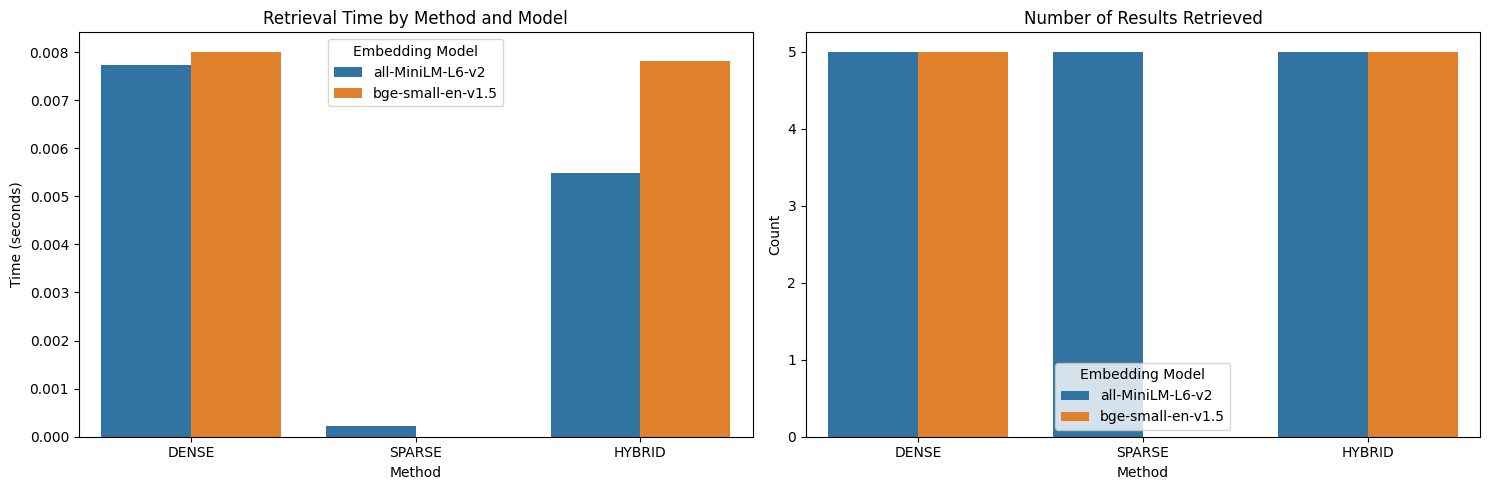


📋 Comparison Summary:
            Model Method  Time (s)  Num Results
 all-MiniLM-L6-v2  DENSE  0.007728            5
 all-MiniLM-L6-v2 SPARSE  0.000233            5
 all-MiniLM-L6-v2 HYBRID  0.005490            5
bge-small-en-v1.5  DENSE  0.008011            5
bge-small-en-v1.5 SPARSE  0.000000            0
bge-small-en-v1.5 HYBRID  0.007809            5


In [11]:
# Cell 11: Visualize Results

print("📊 Generating visualizations...\n")
df_comparison = visualize_comparison(results)

print("\n📋 Comparison Summary:")
print(df_comparison.to_string(index=False))

In [12]:
# Cell 12: Overlap Analysis Between Models

model_keys = list(embeddings_dict.keys())

if len(model_keys) >= 2:
    print("🔄 Analyzing overlap between embedding models...\n")
    
    for method in ['dense', 'hybrid']:
        overlap_stats = overlap_analysis(
            results, 
            model_keys[0], 
            model_keys[1], 
            method=method,
            top_n=5
        )
        print()

🔄 Analyzing overlap between embedding models...


OVERLAP ANALYSIS: minilm vs bge_small (DENSE)
Top-5 Overlap: 1/5 (20.0%)

Unique to minilm: 4
Unique to bge_small: 4


OVERLAP ANALYSIS: minilm vs bge_small (HYBRID)
Top-5 Overlap: 3/5 (60.0%)

Unique to minilm: 2
Unique to bge_small: 2



In [13]:
# Cell 13: Batch Testing Multiple Queries

def batch_compare(queries: List[str], k: int = 5):
    """
    Run comparison across multiple queries and aggregate results
    """
    all_results = []
    
    for i, query in enumerate(queries, 1):
        print(f"\n{'#'*80}")
        print(f"QUERY {i}/{len(queries)}")
        print(f"{'#'*80}\n")
        
        result = compare_retrievals(query, k=k)
        all_results.append(result)
        
        print(f"\n✅ Query {i} complete\n")
    
    return all_results

# Run batch comparison
print("🔄 Running batch comparison on all test queries...\n")
all_results = batch_compare(test_queries, k=5)

🔄 Running batch comparison on all test queries...


################################################################################
QUERY 1/3
################################################################################

QUERY: What is BERT and what does it stand for?

MODEL: MINILM - sentence-transformers/all-MiniLM-L6-v2

🔍 Method 1: DENSE (Vector Similarity)
--------------------------------------------------------------------------------
⏱️  Retrieval time: 0.0181s
1. [Score: 0.8310] the [MASK] symbol for MLM; SAME means that we keep the target token as is; RND means that we replace the target token wi...
2. [Score: 0.9119] is to ﬁne-tune models pre-trained with Ima- geNet (Deng et al., 2009; Yosinski et al., 2014). 3 BERT We introduce BERT a...
3. [Score: 0.9234] he bought a gallon [MASK] milk [SEP] Label = IsNext Input = [CLS] the man [MASK] to the store [SEP] penguin [MASK] are f...

🔍 Method 2: SPARSE (BM25)
-------------------------------------------------------------------


AGGREGATE PERFORMANCE STATISTICS
            Model Method  Avg Time (s)  Std Time (s)  Min Time (s)  Max Time (s)  Total Queries
 all-MiniLM-L6-v2  DENSE      0.009228      0.006251      0.004489      0.018060              3
 all-MiniLM-L6-v2 SPARSE      0.000276      0.000187      0.000130      0.000539              3
 all-MiniLM-L6-v2 HYBRID      0.007361      0.003419      0.004819      0.012194              3
bge-small-en-v1.5  DENSE      0.007938      0.000413      0.007386      0.008378              3
bge-small-en-v1.5 SPARSE      0.000000      0.000000      0.000000      0.000000              3
bge-small-en-v1.5 HYBRID      0.007981      0.000123      0.007853      0.008146              3


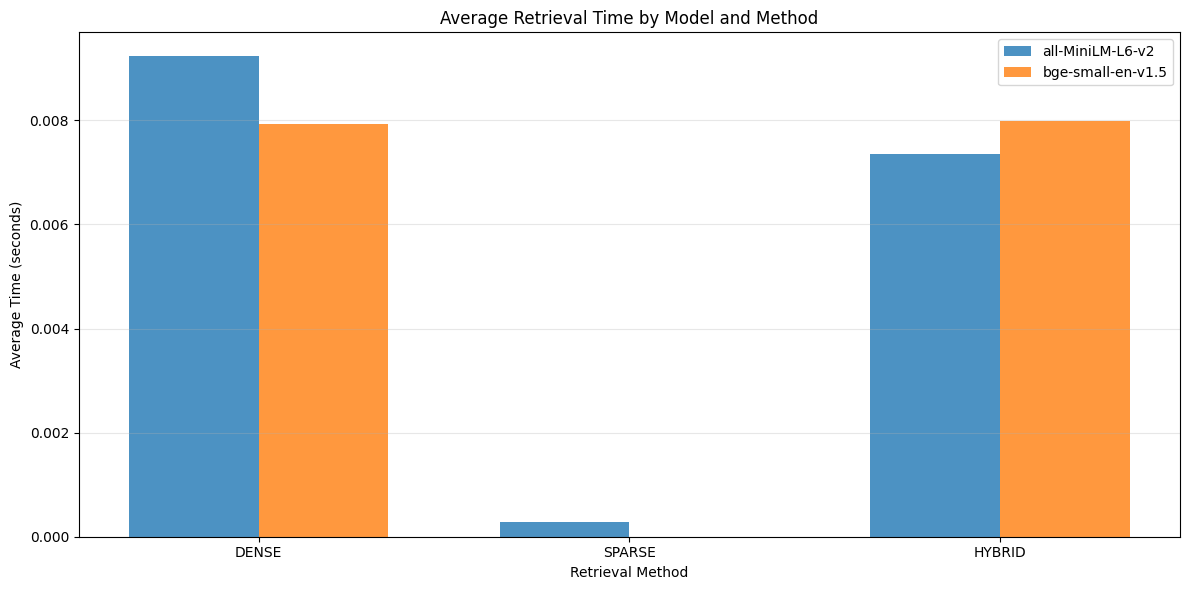

In [14]:
# Cell 14: Aggregate Performance Statistics

def aggregate_performance(all_results):
    """
    Aggregate performance metrics across all queries
    """
    stats_data = []
    
    for model_key in embeddings_dict.keys():
        for method in ['dense', 'sparse', 'hybrid']:
            times = []
            for result in all_results:
                if method in result['models'][model_key]:
                    times.append(result['models'][model_key][method]['time'])
            
            if times:
                stats_data.append({
                    'Model': config.EMBEDDING_MODELS[model_key]['name'].split('/')[-1],
                    'Method': method.upper(),
                    'Avg Time (s)': np.mean(times),
                    'Std Time (s)': np.std(times),
                    'Min Time (s)': np.min(times),
                    'Max Time (s)': np.max(times),
                    'Total Queries': len(times)
                })
    
    df_stats = pd.DataFrame(stats_data)
    
    print("\n" + "="*80)
    print("AGGREGATE PERFORMANCE STATISTICS")
    print("="*80)
    print(df_stats.to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(df_stats['Method'].unique()))
    width = 0.35
    
    models = df_stats['Model'].unique()
    methods = df_stats['Method'].unique()
    
    for i, model in enumerate(models):
        model_data = df_stats[df_stats['Model'] == model]
        avg_times = [model_data[model_data['Method'] == m]['Avg Time (s)'].values[0] 
                     if len(model_data[model_data['Method'] == m]) > 0 else 0 
                     for m in methods]
        plt.bar(x + i*width, avg_times, width, label=model, alpha=0.8)
    
    plt.xlabel('Retrieval Method')
    plt.ylabel('Average Time (seconds)')
    plt.title('Average Retrieval Time by Model and Method')
    plt.xticks(x + width/2, methods)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return df_stats

# Generate aggregate stats
df_aggregate = aggregate_performance(all_results)

In [15]:
# Cell 15: Summary and Recommendations

print("\n" + "="*80)
print("SUMMARY & RECOMMENDATIONS")
print("="*80)

print("\n📊 Embedding Models Tested:")
for key, model_info in config.EMBEDDING_MODELS.items():
    print(f"  • {key}: {model_info['name']}")
    print(f"    Dimensions: {model_info['dims']}")
    print(f"    Description: {model_info['description']}")

print("\n🔍 Retrieval Methods Tested:")
print("  1. DENSE: Vector similarity using embeddings")
print("  2. SPARSE: BM25 keyword matching")
print("  3. HYBRID: Reciprocal Rank Fusion (Dense + BM25)")

print("\n📈 Key Findings:")
print("  • Check the aggregate statistics above for performance comparison")
print("  • Dense retrieval time varies by embedding model")
print("  • BM25 (sparse) is model-independent and typically fastest")
print("  • Hybrid combines strengths of both approaches")

print("\n💡 Next Steps:")
print("  1. Test with more queries to get statistically significant results")
print("  2. Implement reranking for final result refinement")
print("  3. Add LLM-based evaluation (faithfulness, relevance)")
print("  4. Test with different alpha values for hybrid search")
print("  5. Consider GPU acceleration for larger embedding models")

print("\n" + "="*80)
print("✅ COMPARISON COMPLETE")
print("="*80)


SUMMARY & RECOMMENDATIONS

📊 Embedding Models Tested:
  • minilm: sentence-transformers/all-MiniLM-L6-v2
    Dimensions: 384
    Description: Fast, lightweight model
  • bge_small: BAAI/bge-small-en-v1.5
    Dimensions: 384
    Description: Better quality, same size

🔍 Retrieval Methods Tested:
  1. DENSE: Vector similarity using embeddings
  2. SPARSE: BM25 keyword matching
  3. HYBRID: Reciprocal Rank Fusion (Dense + BM25)

📈 Key Findings:
  • Check the aggregate statistics above for performance comparison
  • Dense retrieval time varies by embedding model
  • BM25 (sparse) is model-independent and typically fastest
  • Hybrid combines strengths of both approaches

💡 Next Steps:
  1. Test with more queries to get statistically significant results
  2. Implement reranking for final result refinement
  3. Add LLM-based evaluation (faithfulness, relevance)
  4. Test with different alpha values for hybrid search
  5. Consider GPU acceleration for larger embedding models

✅ COMPARISON CO